# IE 7300 Project

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
from svm_utils  import *

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
df.columns = df.columns.str.replace(' ', '')

In [4]:
df['shares'].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

## Data Pre-Processing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

In [6]:
df.isnull().sum() / df.shape[0] * 100

url                             0.0
timedelta                       0.0
n_tokens_title                  0.0
n_tokens_content                0.0
n_unique_tokens                 0.0
                               ... 
title_subjectivity              0.0
title_sentiment_polarity        0.0
abs_title_subjectivity          0.0
abs_title_sentiment_polarity    0.0
shares                          0.0
Length: 61, dtype: float64

In [7]:
df.drop(labels = ['url', 'timedelta', 'n_non_stop_unique_tokens', 'kw_avg_min'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 39644 non-null  float64
 1   n_tokens_content               39644 non-null  float64
 2   n_unique_tokens                39644 non-null  float64
 3   n_non_stop_words               39644 non-null  float64
 4   num_hrefs                      39644 non-null  float64
 5   num_self_hrefs                 39644 non-null  float64
 6   num_imgs                       39644 non-null  float64
 7   num_videos                     39644 non-null  float64
 8   average_token_length           39644 non-null  float64
 9   num_keywords                   39644 non-null  float64
 10  data_channel_is_lifestyle      39644 non-null  float64
 11  data_channel_is_entertainment  39644 non-null  float64
 12  data_channel_is_bus            39644 non-null 

<AxesSubplot: >

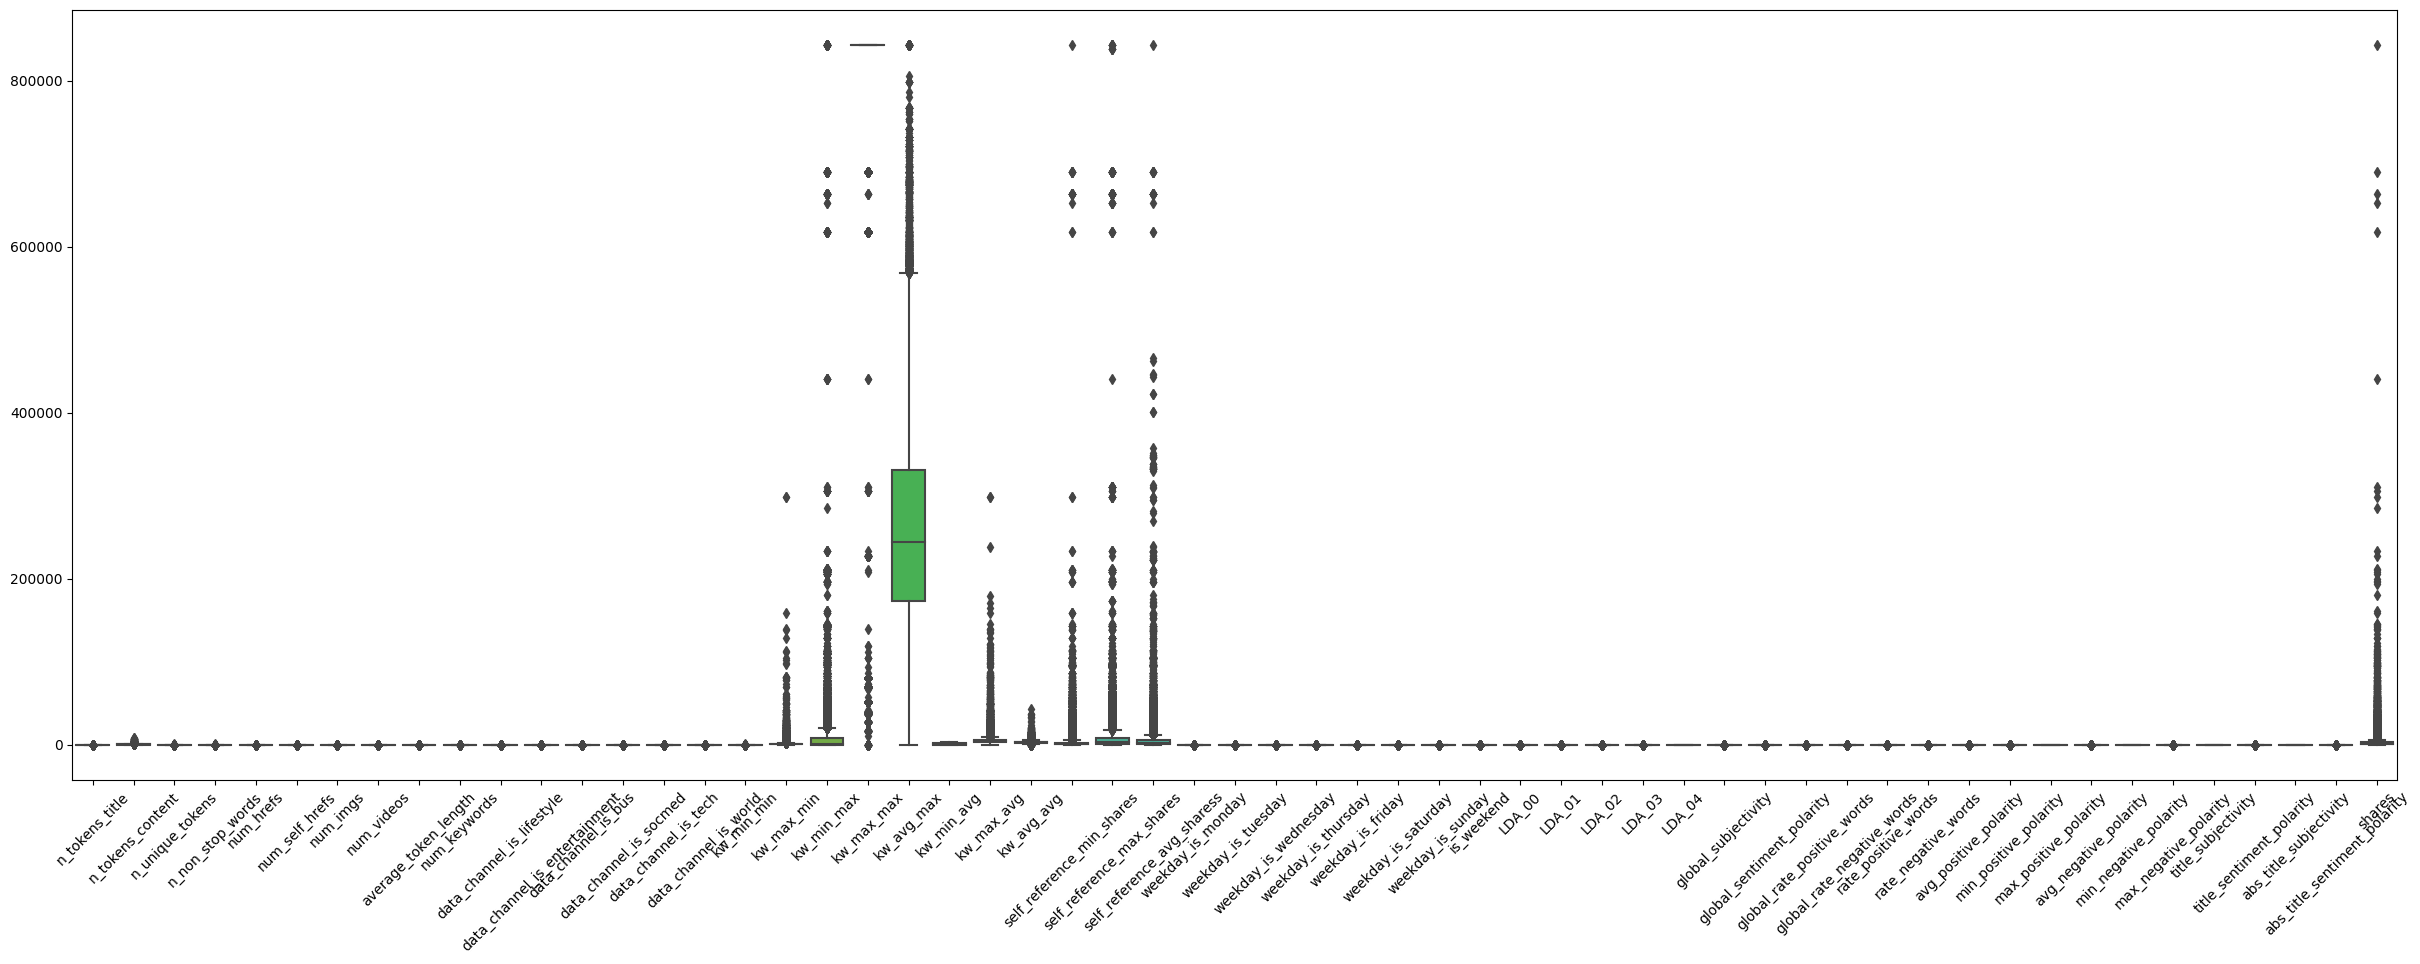

In [8]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=45)
sns.boxplot(data = df)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df[:] = ss.fit_transform(df)

In [ ]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=45)
sns.boxplot(data = df)

In [ ]:
def remove_outliers(array, k=1.5):
    ul = array.mean() + k*array.std()
    ll = array.mean() - k*array.std()
    array[array<ll] = ll
    array[array>ul] = ul
    return array

In [ ]:
df = df.apply(remove_outliers)

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=45)
sns.boxplot(data = df)

## Exploratory Data Analysis

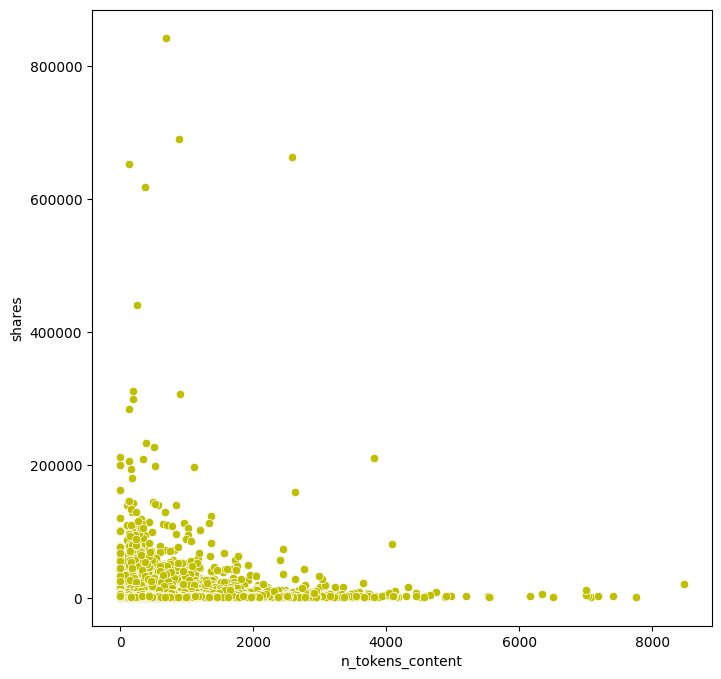

In [9]:
# Seeing if the words in the content affect the number of shares
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(y='shares', x='n_tokens_content', data=df, color='y')

In [10]:
avg = df['shares'].median()
Week_day = df.columns.values[27:34]
print(Week_day)

['weekday_is_monday' 'weekday_is_tuesday' 'weekday_is_wednesday'
 'weekday_is_thursday' 'weekday_is_friday' 'weekday_is_saturday'
 'weekday_is_sunday']


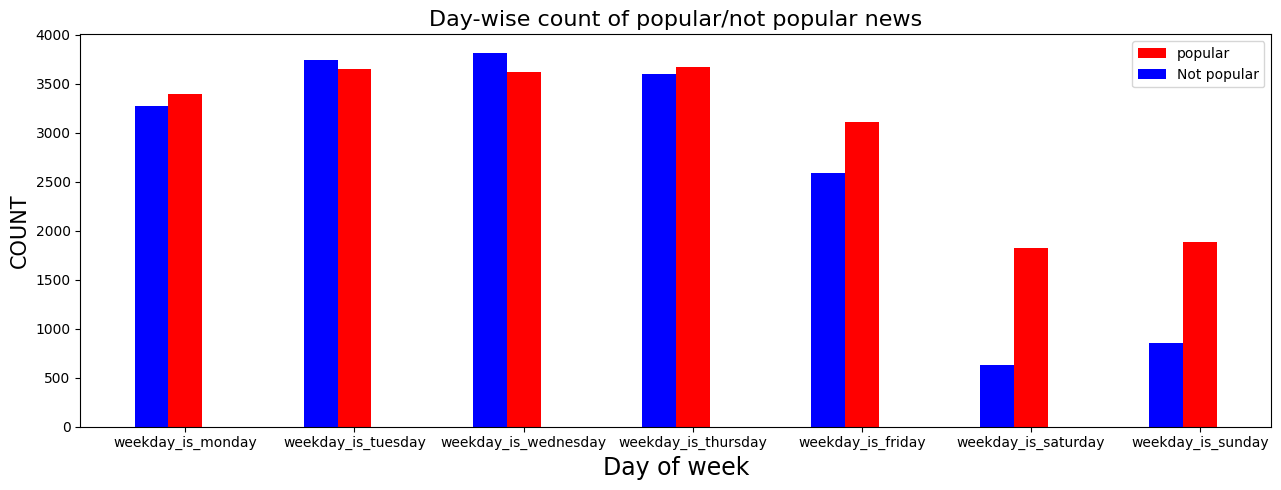

In [11]:
not_popular = df[df['shares']<avg]
popular = df[df['shares']>=avg]

not_popular_day = not_popular[Week_day].sum().values
popular_day = popular[Week_day].sum().values

fig = plt.figure(figsize = (13, 5))
plt.title('Day-wise count of popular/not popular news', fontsize=16)

plt.bar(np.arange(len(Week_day)), popular_day, width=0.2, align='center', color='r', label='popular')
plt.bar(np.arange(len(Week_day))-0.2, not_popular_day, width=0.2, align='center', color='b', label='Not popular')

plt.xticks(np.arange(len(Week_day)), Week_day)
plt.ylabel('COUNT', fontsize=15)
plt.xlabel('Day of week', fontsize=17)

plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

In [12]:
sentiment_of_word = df.columns.values[44:46]
print(sentiment_of_word)

['rate_positive_words' 'rate_negative_words']


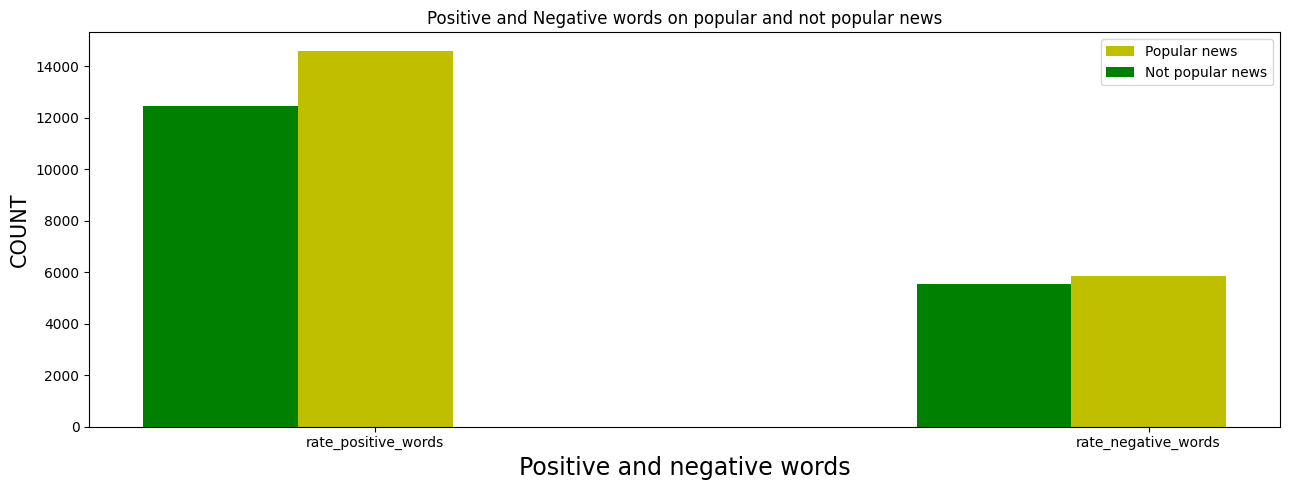

In [13]:
not_popular_senti = not_popular[sentiment_of_word].sum().values
popular_senti = popular[sentiment_of_word].sum().values


fig = plt.figure(figsize=(13, 5))
plt.title('Positive and Negative words on popular and not popular news')

plt.bar(np.arange(len(sentiment_of_word)), popular_senti, width=0.2, align='center', color='y', label='Popular news')
plt.bar(np.arange(len(sentiment_of_word))-0.2, not_popular_senti, width=0.2, align='center', color='g', label='Not popular news')



plt.xticks(np.arange(len(sentiment_of_word)),sentiment_of_word)
plt.ylabel('COUNT', fontsize=15)
plt.xlabel('Positive and negative words', fontsize=17)

plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

In [14]:
a=(df['n_tokens_content']==0).sum()
b=(df['num_videos']==0).sum()
print(a)
print(b)

1181
25026


## Statistical modelling

In [ ]:
X = df.loc[:, df.columns != 'shares']
y = df[['shares']]

In [15]:
df['popularity'] = df['shares'].apply(lambda x: 0 if x <1400 else 1)

In [16]:
X = df.drop(['popularity'], axis = 1)
y = df['popularity']

In [18]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: popularity, dtype: int64

In [19]:
class LogisticRegression:
    
    def __init__(self, X, y, learningRate, tolerance, maxIteration, batchSize):
        
        self.X= X
        self.y = y
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.batchSize = batchSize
        
        
    def splitData(self):
        
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        X_train = self.add_X0(X_train)
        X_valid = self.add_X0(X_valid)
        X_test = self.add_X0(X_test)
        return X_train, X_valid, X_test, y_train, y_valid, y_test

    
    # Normalizing the training dataset using Z-score
#     def normalize(self, X):
#         mean = np.mean(X, 0)
#         std = np.std(X, 0)
        
#         X_norm = (X-mean) / std
#         X_norm = self.add_X0(X_norm)
#         return X_norm, mean, std
    
    
#     def normalizeTestData(self, X, train_mean, train_std):
#         X_norm = (X - train_mean) / train_std
#         X_norm = self.add_X0(X_norm)
#         return X_norm
    
    
    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])
        
    def sigmoid(self,z):
        sig = 1 / ( 1 + np.exp(-z))
        return sig
    
    def predict(self,X):
        pred = self.sigmoid(X.dot(self.w))
        return np.around(pred)
    
    def costFunction(self, X, y):
        pred =np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w)*y
        cost = pred.sum( )
        return cost
    
    def gradient(self,X,y):
        sig = self.sigmoid(X.dot(self.w))
        # sig = self.sigmoid(self.predict(X))
        grad = (sig -y ).dot(X)
        return grad
    
    def gradientDescent(self, X, y):
        errors = []
        last = float('inf')
        
        for i in range(self.maxIteration):
            self.w = self.w - self.learningRate*self.gradient(X,y)
            curr = self.costFunction(X,y)
            
            diff = last - curr
            #last - curr
            last = curr
            
            errors.append(curr)
            
            if diff < self.tolerance:
                print("The model stopped Learning")
                break
        # self.plot_cost(errors)

    def stochasticGD(self, X, y):
        X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
        XY = np.c_[X.reshape(X.shape[0], X.shape[1]), y.reshape(X.shape[0], 1)]
        
        
        # Set seed
        np.random.seed(2022)
        errors = []
        
        for i in tqdm(range(self.maxIteration)):
                    
        # Shuffle x and y
            np.random.shuffle(XY)

            start = 0
            stop = start + self.batchSize
            X_batch, y_batch = XY[start:stop, :-1], XY[start:stop, -1]

          
            last_error = float('inf')

          # Recalculating the difference
            self.w = self.w - self.learningRate * self.gradient(X_batch, y_batch)
            current_error = self.costFunction(X, y)
         
            diff = last_error - current_error
            last_error = current_error

            errors.append(current_error)
            if np.abs(diff) < self.tolerance:
                print('Model stopped learning')
                break
        
        print(self.w)
        
        
    def evaluate(self, y, y_hat):
        
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        #accuracy = np.sum(np.equal(y_true, y_hat)) / len(y_true)
        accuracy = (y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        
        return accuracy, precision, recall
    
    def fit(self):

        X_train, X_valid, X_test, y_train, y_valid, y_test = self.splitData()
        self.w = np.dot(np.ones(X_train.shape[1], dtype = np.float64), 0)
        self.stochasticGD(X_train, y_train)
        # self.gradientDescent(X_train, y_train)
        y_hat_train = self.predict(X_train)
        recall, precision, accuracy = self.evaluate(y_train,y_hat_train)
        return accuracy, precision, recall
        
    def validation(self):
        X_train, X_valid, X_test, y_train, y_valid, y_test = self.splitData()
        y_hat_valid = self.predict(X_valid)

        recall, precision, accuracy  = self.evaluate(y_valid, y_hat_valid)
        return accuracy, precision, recall

    def test(self):
        X_train, X_valid, X_test, y_train, y_valid, y_test = self.splitData()
        y_hat_test = self.predict(X_test)
        recall, precision, accuracy  = self.evaluate(y_test, y_hat_test)
        return accuracy, precision, recall

In [20]:
# data = [X_train, y_train, X_valid, y_valid, X_test, y_test]
lr = LogisticRegression(X = df.values[:, 0:-1], y = df.values[:, -1], learningRate = 0.0001, tolerance = 0.0001, maxIteration = 100, batchSize=32)
log_base_train_acc = lr.fit()
log_base_valid_acc = lr.validation()
log_base_test_acc = lr.test()
display(log_base_train_acc, log_base_valid_acc, log_base_test_acc)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Amogha Shettar\AppData\Local\Temp\ipykernel_1616\3111172087.py:51: RuntimeWarning: overflow encountered in exp
  pred =np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w)*y
C:\Users\Amogha Shettar\AppData\Local\Temp\ipykernel_1616\3111172087.py:105: RuntimeWarning: invalid value encountered in double_scalars
  diff = last_error - current_error
  2%|█▋                                                                                | 2/100 [00:00<00:05, 17.25it/s]C:\Users\Amogha Shettar\AppData\Local\Temp\ipykernel_1616\3111172087.py:43: RuntimeWarning: overflow encountered in exp
  sig = 1 / ( 1 + np.exp(-z))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.19it/s]


[ 4.00000000e-04 -8.70000000e-03  7.68960000e+00 -1.57029963e-03
  7.50000034e-04  1.55250000e-01  3.10500000e-02  5.74000000e-02
 -2.95000000e-03  6.19422559e-04  2.62000000e-02  1.10000000e-03
 -8.20000000e-03  8.50000000e-04  5.05000000e-03  7.20000000e-03
 -9.00000000e-03  5.91250000e-01 -3.91632820e+01 -3.42902000e+01
 -1.11172500e+03 -3.68643565e+02  1.34422360e+01  6.05324403e+01
  3.40403233e+01  1.74754059e+02  4.16812650e+02  2.62669340e+02
 -2.75000000e-03 -4.20000000e-03 -2.45000000e-03 -1.50000000e-04
  2.55000000e-03  4.75000000e-03  2.65000000e-03  7.40000000e-03
  3.09327033e-03 -2.52155386e-03 -5.82324133e-03  3.55752140e-04
  5.29577271e-03  1.15149359e-03  1.16946643e-03  2.18086081e-04
 -5.41077078e-05  2.48375582e-03 -1.73375582e-03  4.11625078e-04
 -8.63086580e-04  2.75108874e-03 -5.03168017e-04 -2.62267857e-03
  5.90491453e-05  1.55436207e-04  1.79816174e-03 -9.75829125e-05
  1.15226996e-03  3.59085200e+02]


(0.002010218611273976, 0.42857142857142855, 0.46184684684684685)

(0.001717032967032967, 0.45454545454545453, 0.4751351351351351)

(0.0007932730445819451, 0.29411764705882354, 0.469480410290903)

In [ ]:
class MaxMarginClassifier:
    
    def __init__(self, C):
#         self.X = X
#         self.y = y
        self.alpha = None
        self.w = None
        self.C = C 
    
    
#     def splitData(self):
        
#         X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
#         return X_train, X_test, y_train, y_test
    
    
    def fit(self, X, y):

#         X_train, X_test, y_train, y_test = self.splitData()
        N = len(y)
        #Gram matrix
        Xy = X*y[:, np.newaxis] # newmatrix converts a vector into matrix

        print(Xy.shape)
        print(Xy.T.shape)
        GramXy = np.matmul(Xy, Xy.T)
        print(GramXy.shape)
        
        def Ld0(G, alpha):
            obj_fn = alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
            return obj_fn
        
        def partialDerivativeLd0(G, alpha):
            par_der = np.ones_like(alpha) - alpha.dot(G)
            return par_der
    
        #initialize x0 = alphas
          
        alpha = np.ones(N)     #dtype='uint8'
        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.concatenate((np.zeros(N), self.C * np.ones(N)))

        constraints = ({'type': 'eq', 'fun': lambda a: np.dot(a,y), 'jac': lambda a:y},
                       {'type': 'ineq', 'fun': lambda a: b-np.dot(A,a), 'jac': lambda a:-A})




        optRes = optimize.minimize(fun = lambda a: -Ld0(GramXy, a),
                                   x0 = alpha,
                                   jac = lambda a: -partialDerivativeLd0(GramXy, a),
                                   constraints = constraints
                                   )

        self.alpha = optRes.x

        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis = 0)

        epsilon = 1e-4    
        self.supportVectors = X[self.alpha > epsilon]
        self.supportLabels = y[self.alpha > epsilon]

        b = []
        for i in range(len(self.supportLabels)):
            b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
            b.append(b_i)
        self.b = sum(b)/len(b)


In [ ]:
# model = MaxMarginClassifier(X = df.values[:, 0:-1], y = df.values[:, -1], C = 5)

model = MaxMarginClassifier(C = 5)

In [ ]:
X = df.values[:, 0:-1]
y = df.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.w

In [ ]:
model.b

In [ ]:
class SMO():
    def __init__(self, max_iter=100, kernel_type='linear', C=1.0, epsilon=1e-4):
        self.kernels = {
            'linear' : self.kernel_linear,
            'poly' : self.kernel_poly,
            'rbf' : self.kernel_rbf
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon

    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break
            #print(count)
            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]

        return support_vectors, count

    def predict(self, X):
        return self.h(X, self.w, self.b)

    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)

    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))

    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)

    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k

    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))

    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = np.random.randint(a,b)
            cnt=cnt+1
        return i

    def kernel_linear(self, x, z):
        return np.dot(x, z.T)

    def kernel_poly(self, x, z):
        return (np.dot(x, z.T) ** 2)

    def kernel_rbf(self, x, z, sigma=1):
        return np.exp(- (np.linalg.norm(x - z, 2)) ** 2 / (2 * sigma ** 2))

    def predict_proba(self, X):
        return np.dot(self.w.T, X.T) + self.b

In [ ]:
model = SMO(C=5)
model.fit(X_train, y_train)